# Ensemble Learning through Batch Boosting


In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from stochastic_models import *
from visualisations import *
from basic_estimator_model import *

## Parameter Configuration

In [2]:
np.random.seed(2020)

In [3]:
N_train =1000
N_test = 50000
Max_Iter = 100
Ratio = 0.30
d = 1
T = 2

In [4]:
lambda_range = (N_train*1e-9 , N_train*1e-3)
alpha_range = (8.3*1e-5, 0.83)
length_scale = np.sort(1/np.sqrt((2*alpha_range[0], 2*alpha_range[1])))

## Create Kernel & prepare datasets

In [5]:
#kernel
kernel = RBF(length_scale= (length_scale[0] + length_scale[1])/2, length_scale_bounds=length_scale) \
        + WhiteKernel(noise_level= (lambda_range[0] + lambda_range[1])/2 , noise_level_bounds=lambda_range)


In [6]:
#generate drivers
s_train = MaxCallStochasticModel(N_train,d,[1/12,11/12])
s_train.generate_samples()
s_test = MaxCallStochasticModel(N_test, d, [1/12,11/12])
s_test.generate_samples()

In [7]:
y_train = s_train.y
X_train = s_train.X
S_train = s_train.S

y_test = s_test.y
X_test = s_test.X
S_test = s_test.S

V_T = s_test.generate_true_V(T)
V_0 = s_test.generate_true_V(0)

V_T_train = s_train.generate_true_V(T)
V_0_train = s_train.generate_true_V(0)

V_0_train = V_0_train.mean()
V_0= V_0.mean()
V_0 # Average expected PROFIT!

0.07966926864511534

In [8]:
from aggregating.utils import flatten_X, normalized_error_VT
#dim(N_test,d*T)
Flattened_X_test = flatten_X(X_test)
# dim(N_train, d*T)
Flattened_X_train = flatten_X(X_train)

In [9]:
#Model with Flatten_X_1
m_1 = EstimatorModelBase(kernel)
m_1.fit(Flattened_X_train,y_train)

GaussianProcessRegressor(kernel=RBF(length_scale=39.2) + WhiteKernel(noise_level=0.5))

In [10]:
fX_1 = m_1._predict_fX(Flattened_X_test)

In [34]:
fX_2 = m_1._predict_fX(Flattened_X_train)

In [35]:
normalized_error_VT(fX_1 ,V_T, V_0)

0.19087255877978457

In [36]:
reference_error = normalized_error_VT(fX_2 ,V_T_train, V_0_train)

In [37]:
reference_error

0.022946493453321455

## Batch Boosting

In [13]:
def Bacth_Boosting(X_train, y_train, Max_Iter, min_error, early_stop):
    error_going_up = 0
    final_prediction = np.zeros(N_train)
    previous_y_hat = np.zeros(N_train)
    previous_predictions = np.zeros((Max_Iter, N_train))
    models = []
    errors = []
    original_y_train = y_train
    y = y_train
    for i in range(Max_Iter):
        model = GaussianProcessRegressor(kernel)
    
        y = y - previous_y_hat
    
        model.fit(X_train, y)
        models.append(model)
    
        previous_predictions[i,:] = model.predict(X_train) 
        previous_y_hat = previous_predictions[i,:]
    
    
        final_prediction += previous_y_hat
     
        errors.append(normalized_error_VT(final_prediction,original_y_train,V_0_train).item())
    
        if (errors[-1] < min_error):
            min_error = errors[-1]
            error_going_up = 0
            nb_of_models = i
            print('For iteration number {}, the error decreased '.format(i))
        else:
            error_going_up += 1
            print('For iteration number {}, the error increased '.format(i))
        
            if  (i==(Max_Iter-1)):
                models = models[:nb_of_models+1]
                return models, errors
        
            elif (error_going_up == early_stop ):
                models = models[: -early_stop]
                return models, errors
                break #early stopping
            
    return models, errors

In [38]:


models, error = Bacth_Boosting(Flattened_X_train, y_train, 200, float("inf"), 50)

For iteration number 0, the error decreased 
For iteration number 1, the error decreased 
For iteration number 2, the error increased 
For iteration number 3, the error increased 
For iteration number 4, the error decreased 
For iteration number 5, the error increased 
For iteration number 6, the error decreased 
For iteration number 7, the error increased 
For iteration number 8, the error increased 
For iteration number 9, the error increased 
For iteration number 10, the error increased 
For iteration number 11, the error increased 
For iteration number 12, the error decreased 
For iteration number 13, the error decreased 
For iteration number 14, the error increased 
For iteration number 15, the error increased 
For iteration number 16, the error increased 
For iteration number 17, the error increased 
For iteration number 18, the error decreased 
For iteration number 19, the error decreased 
For iteration number 20, the error decreased 
For iteration number 21, the error increased

For iteration number 177, the error increased 
For iteration number 178, the error increased 
For iteration number 179, the error increased 
For iteration number 180, the error increased 
For iteration number 181, the error increased 
For iteration number 182, the error increased 
For iteration number 183, the error increased 
For iteration number 184, the error decreased 
For iteration number 185, the error decreased 
For iteration number 186, the error decreased 
For iteration number 187, the error decreased 
For iteration number 188, the error increased 
For iteration number 189, the error decreased 
For iteration number 190, the error decreased 
For iteration number 191, the error decreased 
For iteration number 192, the error increased 
For iteration number 193, the error increased 
For iteration number 194, the error increased 
For iteration number 195, the error increased 
For iteration number 196, the error decreased 
For iteration number 197, the error decreased 
For iteration

In [39]:
y_pred = sum(m.predict(Flattened_X_test) for m in models)

In [40]:
normalized_error_VT(y_pred , V_T, V_0).item()

0.190872583752359

No handles with labels found to put in legend.


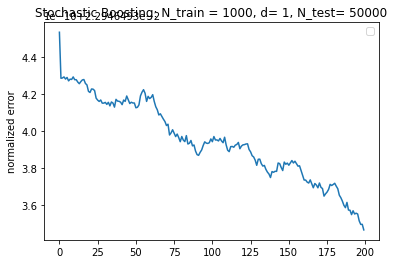

In [41]:
#plt.hlines(reference_error,xmin=0,xmax=29,linestyles='dashed', label = 'reference error')
plt.plot(np.arange(len(error)) , error)
plt.title(f"Stochastic Boosting: N_train = {N_train}, d= {d}, N_test= {N_test}")
plt.xlabel("")

plt.ylabel("normalized error")
plt.legend(loc='upper right')
plt.show()

In [18]:
plt.hlines(reference_error,xmin=Ratios[0],xmax=Ratios[-1],linestyles='dashed')

plt.plot(Ratios, error)
plt.title(f"Stochastic Boosting: N_train = {N_train}, d= {d}, N_test= {N_test}")
plt.xlabel("Ratios")

plt.ylabel("normalized error")
plt.legend(loc='upper right')
plt.show()

NameError: name 'Ratios' is not defined

In [ ]:
errors = []
Max_Iter_Range = 10
Ratios = np.linspace(0.1,1, num=10)
for r in :
    models_1, errors_1 = Stochastic_Boosting(Flattened_X_train, y_train, Max_Iter, float('inf'),\
                                     20, round(Flattened_X_train.shape[0]*r))
    y_stoch_pred = sum(m.predict(Flattened_X_test) for m in models_1)
    errors.append(normalized_error_VT(y_stoch_pred , V_T, V_0))
    
    

## Stochastic Boosting

In [ ]:
def Stochastic_Boosting(X_train, y_train, Max_Iter, min_error, early_stop, sample_size):
    error_going_up = 0
    final_prediction = np.zeros(X_train.shape[0])
    previous_y_hat = np.zeros(X_train.shape[0])
    previous_predictions = np.zeros((Max_Iter, X_train.shape[0]))
    models = []
    errors = []
    original_y_train = y_train
    
    for i in range(Max_Iter):
       
        indices = np.random.choice(X_train.shape[0],size=sample_size,replace=False)
        model = GaussianProcessRegressor(kernel)
        
        y_train[indices] = y_train[indices] - previous_y_hat[indices]
    
        model.fit(X_train[indices], y_train[indices])
        models.append(model)
        
        previous_predictions[i,:] = model.predict(X_train) 
        previous_y_hat = previous_predictions[i,:]
    
    
        final_prediction += previous_y_hat
     
        errors.append(normalized_error_VT(final_prediction,original_y_train, V_0_train).item())
    
        if (errors[-1] < min_error):
            min_error = errors[-1]
            error_going_up = 0
            nb_of_models = i
            print('For iteration number {}, the error decreased '.format(i))
        else:
            error_going_up += 1
            print('For iteration number {}, the error increased '.format(i))
        
            if  (i==(Max_Iter-1)):
                models = models[:nb_of_models+1]
                return models, errors
        
            elif (error_going_up == early_stop ):
                models = models[: -early_stop]
                return models, errors
                break #early stopping
            
    return models, errors

In [ ]:
models_1, errors_1 = Stochastic_Boosting(Flattened_X_train, y_train, Max_Iter, float('inf'),\
                                     20, round(Flattened_X_train.shape[0]*Ratio))

In [ ]:
plt.figure(figsize = (15, 7))

plt.plot(np.arange(len(errors_1)) , errors_1)
plt.show

In [ ]:
y_stoch_pred = sum(m.predict(Flattened_X_test) for m in models_1)

In [ ]:
normalized_error_VT(y_stoch_pred , V_T, V_0)

In [ ]:
errors = []
Max_Iter_Range = 10
Ratios = np.linspace(0.1,1, num=10)
for r in Ratios:
    models_1, errors_1 = Stochastic_Boosting(Flattened_X_train, y_train, Max_Iter, float('inf'),\
                                     20, round(Flattened_X_train.shape[0]*r))
    y_stoch_pred = sum(m.predict(Flattened_X_test) for m in models_1)
    errors.append(normalized_error_VT(y_stoch_pred , V_T, V_0))
    
    

In [ ]:
plt.hlines(reference_error,xmin=Ratios[0],xmax=Ratios[-1],linestyles='dashed')

plt.plot(Ratios, errors)
plt.title(f"Stochastic Boosting: N_train = {N_train}, d= {d}, N_test= {N_test}")
plt.xlabel("Ratios")

plt.ylabel("normalized error")
plt.legend(loc='upper right')
plt.show()

## GridSearch

nB: cannot use Scikit gridsearch as it performs CV and we want to have a different test set of a larger size!

In [ ]:
#reference error: no ensemble
from aggregating.gridsearch import create_logger, evaluate_model
from aggregating.utils import flatten_X

hyperparams= {'M':1, 'train_size_alpha':1.0}
model = GaussianProcessRegressor(kernel)
reference_error = evaluate_model(model,hyperparams,flatten_X(X_train),y_train,1, [1/12,11/12],3,N_test,MaxCallStochasticModel)
reference_error_mean = sum(reference_error)/len(reference_error)
print(reference_error_mean)

In [ ]:
from multiprocessing import  cpu_count,current_process
from multiprocessing.pool import ThreadPool
import functools
import threading

from aggregating.gridsearch import create_logger, evaluate_model
from aggregating.utils import flatten_X

# GRIDSEARCH PARAMS
model = SoftBagger(0,0,GaussianProcessRegressor(kernel,copy_X_train=False))
trials = 3
M_grid = [1,3,5,7,9]
alpha_grid = [0.3,0.5,0.7,1.0]
results = []

### ACTUAL GRIDSEARCH
pool = ThreadPool(4) #avoid allocation issues
for m in M_grid:
    for alpha in alpha_grid:
        hyperparams= {'M':m, 'train_size_alpha':alpha}
        pool.apply_async(evaluate_model, args=(model,hyperparams,flatten_X(X_train),\
            y_train,1, [1/12,11/12],trials,N_test,MaxCallStochasticModel),\
                         callback = create_logger(hyperparams,results))
pool.close()
pool.join()



In [ ]:
converted_results = np.ones((len(M_grid),len(alpha_grid),trials))*(-1)
for item in results:
    print(item)
    converted_results[M_grid.index(item[0]),alpha_grid.index(item[1])] = item[2]

print(converted_results.shape)
print(converted_results)

In [ ]:
masked_results= np.ma.masked_where(converted_results <= 0.0,converted_results) # some runs have been aborted every now and then -> filter them out
means = masked_results.mean(axis=2)
sigmas = masked_results.std(axis=2)
means.shape

In [ ]:
plt.hlines(reference_error_mean,xmin=M_grid[0],xmax=M_grid[-1],linestyles='dashed',label="reference error")
for i in range(len(alpha_grid)):
    plt.errorbar(np.array(M_grid),means[:,i],sigmas[:,i],marker ='o',label = f"alpha = {alpha_grid[i]}")
plt.title(f"Soft Bagging Normalized error: N_train = {N_train}, d= {d}, N_test= {N_test}")
plt.xlabel("M")
plt.xticks(M_grid)
plt.ylabel("normalized error")
plt.legend(loc='upper right')
plt.show()

## Store results

In [ ]:
res_dict = {'N_train': N_train, 'N_test': N_test,'mgrid': M_grid, 'alpha_grid': alpha_grid, 'errors': converted_results.tolist()}

In [ ]:
import json
import datetime
with open(f'soft_bagging_w_replacement_{str(datetime.date.today())}.json', 'w') as fp:
    json.dump(res_dict, fp)